In [2]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from hmpai.pytorch.correlation import *
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch
from hmpai.behaviour.sat2 import read_behavioural_info

In [3]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ["event_name", "participant", "epochs"]
subset_cond = None  # 'speed'|'accuracy'|None
skip_samples = 0

In [4]:
norm_fn = norm_mad_zscore
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}
norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
)

In [5]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader_sat2 = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [6]:
chk_path = Path("../../models/mamba_conv_jitter_both.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "embed_dim": 128,
    "n_channels": 19,
    "n_classes": len(labels),
    "n_layers": 5,
    "global_pool": False,
    "dropout": 0.1,
}
model = MambaModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

model.pretraining = False
model.global_pool = False
model.eval();

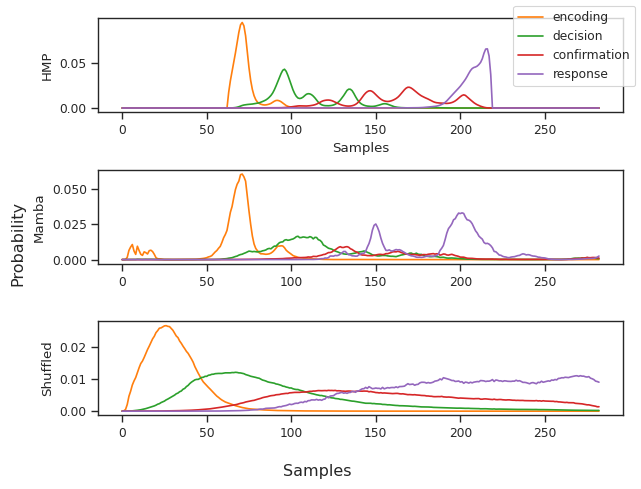

KLDivDiff
(pred, true):       tensor([0.1747, 0.2526, 0.2986, 0.1801])
(shuffled, true):   tensor([0.1618, 0.2491, 0.2909, 0.1776])
pred - shuffled:    tensor([0.0129, 0.0035, 0.0076, 0.0025])
DTW
(pred, true):       tensor([1.3140, 1.5610, 1.0860, 1.6828], dtype=torch.float64)
(shuffled, true):   tensor([1.4314, 1.3407, 1.2024, 2.0911], dtype=torch.float64)
pred - shuffled:    tensor([-0.1174,  0.2203, -0.1164, -0.4083], dtype=torch.float64)
EMD
(pred, true):       tensor([0.0017, 0.0016, 0.0021, 0.0028], dtype=torch.float64)
(shuffled, true):   tensor([0.0032, 0.0026, 0.0029, 0.0066], dtype=torch.float64)
pred - shuffled:    tensor([-0.0015, -0.0010, -0.0008, -0.0037], dtype=torch.float64)
JSD
(pred, true):       tensor([0.7990, 0.6732, 0.6160, 0.7319], dtype=torch.float64)
(shuffled, true):   tensor([0.7879, 0.6503, 0.5569, 0.7179], dtype=torch.float64)
pred - shuffled:    tensor([0.0111, 0.0229, 0.0592, 0.0140], dtype=torch.float64)
Spearman
(pred, true):       tensor([0.0050, 0.04

In [53]:
# SAT2
window_size = 0
amount_of_graphs = 1
counter = 0
n_shuffles = 100

def print_result(name: str, pred: torch.Tensor, shuffled: torch.Tensor):
    print(f"{name}\n{'(pred, true): ':<20}{pred}\n{'(shuffled, true): ':<20}{shuffled}\n{'pred - shuffled: ':<20}{pred - shuffled}")

for batch in test_loader_sat2:
    info = batch[2][0]
    lengths = get_masking_indices(batch[0])
    for epoch, true, participant, trial, length in zip(
        batch[0], batch[1], info["participant"], info["epochs"], lengths
    ):
        plot_predictions_on_epoch(
            epoch,
            true,
            SAT_CLASSES_ACCURACY,
            window_size,
            model,
            smoothing=False,
            sequence=True,
            random_perm=True,
            save_tensors=True,
        )
        epoch = epoch.unsqueeze(0).to(DEVICE)
        pred = model(epoch)
        pred = torch.nn.Softmax(dim=2)(pred)
        # shuffled_pred_log = torch.zeros_like(pred)
        shuffled_pred = torch.zeros_like(pred)

        for _ in range(n_shuffles):
            epoch[0, :length] = epoch[0, torch.randperm(length)]
            single_shuffled_pred = model(epoch)
            # shuffled_pred_log += torch.nn.LogSoftmax(dim=2)(model(epoch))
            shuffled_pred += torch.nn.Softmax(dim=2)(model(epoch))
        # shuffled_pred_log /= n_shuffles
        shuffled_pred /= n_shuffles

        # shuffled_pred = shuffled_pred / shuffled_pred.sum(dim=2, keepdim=True)
        # pred = pred / pred.sum(dim=2, keepdim=True)

        true = true[: pred.shape[1]]
        true = true.unsqueeze(0)

        true_kldiv = true.clone()
        true_kldiv = true_kldiv + 1e-8
        true_kldiv = true_kldiv / true_kldiv.sum(dim=-1, keepdim=True)
        true_kldiv_result = kldiv(pred, true_kldiv)
        shuffled_kldiv = kldiv(shuffled_pred, true_kldiv)
        print_result('KLDivDiff', true_kldiv_result, shuffled_kldiv)

        true_dtw = dtw(pred, true)
        shuffled_dtw = dtw(shuffled_pred, true)
        print_result('DTW', true_dtw, shuffled_dtw)

        true_wasserstein = emd(pred, true)
        shuffled_wasserstein = emd(shuffled_pred, true)
        print_result('EMD', true_wasserstein, shuffled_wasserstein)

        true_jsd = jsd(pred, true)
        shuffled_jsd = jsd(shuffled_pred, true)
        print_result('JSD', true_jsd, shuffled_jsd)

        true_spearman = spearman(pred, true)
        shuffled_spearman = spearman(shuffled_pred, true)
        print_result('Spearman', true_spearman, shuffled_spearman)

        true_pearson = pearson(pred, true)
        shuffled_pearson = pearson(shuffled_pred, true)
        print_result('Pearson', true_pearson, shuffled_pearson)

        true_multiply = multiply(pred, true)
        shuffled_multiply = multiply(shuffled_pred, true)
        print_result('Multiply', true_multiply, shuffled_multiply)

        counter += 1
        if counter >= amount_of_graphs:
            break
    break
# positive means true is greater than shuffled
# negative means shuffled is greater than true
# In case of KLDiv, lower is better, so negative is good
# Spearman and Pearson are correlations, so higher is better, meaning that positive = good
# DTW is distance based, so lower is better, negative = good